In [1]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib
import os
# %matplotlib inline
%matplotlib ipympl
matplotlib.rcParams.update({'font.size': 12,'font.family':'verdana'})
plt.rcParams['figure.dpi'] = 120
%config InlineBackend.figure_format = 'retina'
%load_ext autoreload
%autoreload 2

In [2]:
def get_line(file_path, line_number):
    with open(file_path, 'r') as file:
        lines = file.readlines()
        return lines[line_number - 1]

def shload(filename):
    if not filename:
        print("You need to provide a filename")
        return
    xu1 = xu2 = xl1 = xl2 = 0 # handle cases where iterative procedure diverged

    try:
        with open(filename, 'r') as f:
            for i, line in enumerate(f):
                if line.strip() == 'SHOCK NO.  1 ON UPPER SURFACE.':
                    xu1 = float(get_line(filename, i+3).split()[1])
                elif line.strip() == 'SHOCK NO.  2 ON UPPER SURFACE.':
                    xu2 = float(get_line(filename, i+3).split()[1])
                elif line.strip() == 'SHOCK NO.  1 ON LOWER SURFACE.':
                    xl1 = float(get_line(filename, i+3).split()[1])
                elif line.strip() == 'SHOCK NO.  2 ON LOWER SURFACE.':
                    xl2 = float(get_line(filename, i+3).split()[1])
    except FileNotFoundError:
        print("File does not exist")
    
    return xu1, xu2, xl1, xl2

def airload(filename):
    if not filename:
        print("You need to provide a filename")
        return
    Xupper = CPupper = Xlower = CPlower = []; em = cl = 0; cdv = {} # handle cases where iterative procedure diverged

    try:
        with open(filename, 'r') as f:
            for line in f:
                if line.startswith(' ITERATIVE PROCEDURE HAS DIVERGED'):
                    break
                elif line.startswith(' EM ='):
                    em = line.split()[2]
                elif line.startswith('   CL ='):
                    cl = float(line.split()[2])
                elif line.startswith('  CDV ='):
                    cdv["cdv"] = float(line.split()[2])
                elif line.startswith('  CDV+CD1 ='):
                    cdv["cdv+cd1"] = float(line.split()[2])
                    cdv["cdv+cd2"] = float(line.split()[5])
                elif line.strip() == 'Upper surface CP values':
                    Xupper = []
                    CPupper = []
                    for line in f:
                        if line.strip() == 'Lower surface CP values':
                            break
                        # elif line.strip() == 'X          CP':
                        elif line.strip() == 'X          CP' or '*' in line:
                            True
                        else:
                            strs = line.split()
                            Xupper.append(float(strs[0]))
                            CPupper.append(float(strs[1]))
                    Xlower = []
                    CPlower = []
                    for line in f:
                        if not line.strip():
                            break
                        elif line.strip() == 'X          CP':
                            True
                        else:
                            strs = line.split()
                            if len(strs) == 2:
                                Xlower.append(float(strs[0]))
                                CPlower.append(float(strs[1]))
    except FileNotFoundError:
        print("File does not exist")
    
    return Xupper, CPupper, Xlower, CPlower, em, cl, cdv

def plot_cp(filename):
    plt.clf()
    Xupper, CPupper, Xlower, CPlower, em, cl, cdv = airload(filename)
    if cl != 0:
        print("CL: ", cl)
        if abs(cdv['cdv+cd1'] - cdv['cdv+cd1']) <= 0.04: # acceptable error
            print("CD2: ", cdv['cdv+cd2'] - cdv['cdv']) # use viscous cdv
        else:
            print("CD2 (inaccurate): ", cdv['cdv+cd2'] - cdv['cdv'])
    mach = float(em)
    cpstar = 2/1.4/mach/mach*(((2+0.4*mach*mach)/2.4)**3.5-1)
    plt.plot(Xupper, CPupper, 'r', label='Suction Surface') 
    plt.plot(Xlower, CPlower, 'b', label='Pressure Surface')
    plt.xlabel('x/c')
    plt.ylabel('-Cp')
    plt.axis([0, 1, -2, 1])
    plt.gca().invert_yaxis()
    plt.grid(True)
    plt.plot([0, 1], [cpstar, cpstar], 'g', label='Cp* ( M$_{loc}$ = 1.0 )')
    plt.legend()
    plt.show()

def plot_shape(filename):
    plt.clf()
    data = np.loadtxt(filename, skiprows=2)
    xu = data[:65, 0]
    xl = data[65:, 0]
    yu = data[:65, 1]
    yl = data[65:, 1]
    plt.plot(xu, yu, label='Suction Surface')
    plt.plot(xl, yl, label='Pressure Surface')
    plt.plot(xu, (yu + yl)/ 2, label='Mean Camber Line')
    plt.legend()
    plt.axis([0, 1, -0.5, 0.5])
    plt.axis('equal')
    plt.show()

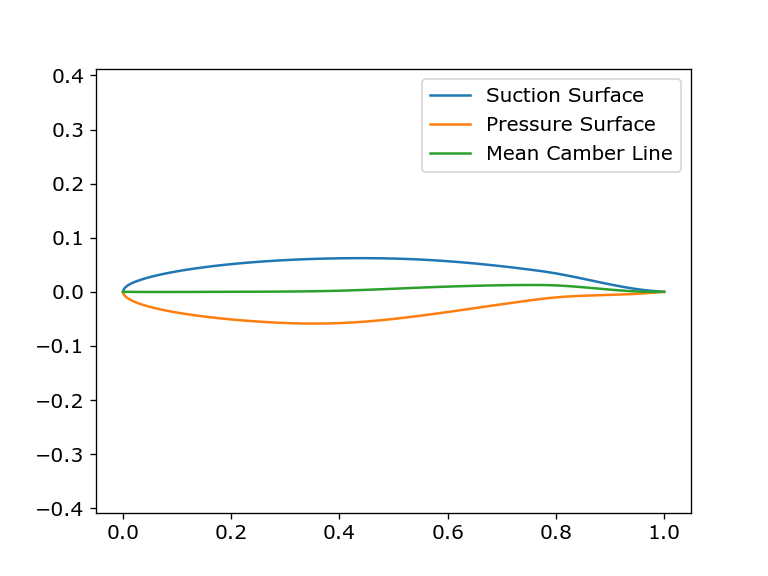

In [9]:
plot_shape("../sample/run.report.100.dat")
plt.plot([0.02, 0.02], [-0.2, 0.2], 'k--')
plt.plot([0.45, 0.45], [-0.2, 0.2], 'k--', label='Shock Location')
plt.savefig('../results/python/shape.png', dpi=300)

CL:  0.60198
CD2:  0.0009199999999999989


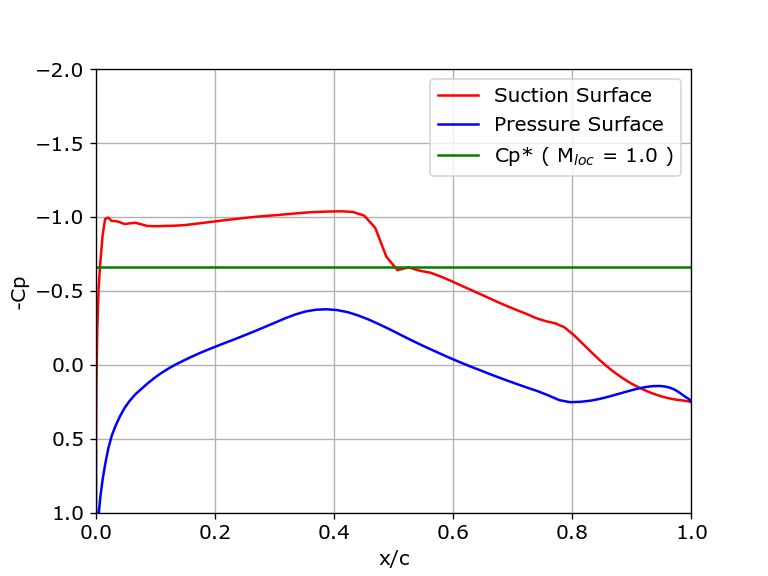

In [10]:
plot_cp('../results/report-1.00/0.73-9.00-+2.29/Autorun.BRF')
plt.plot([0.02, 0.02], [-2, 1], 'k--')
plt.plot([0.45, 0.45], [-2, 1], 'k--', label='Shock Location')
plt.savefig('../results/python/cp_op.png', dpi=300)

CL:  0.60198
CD2:  0.0009199999999999989


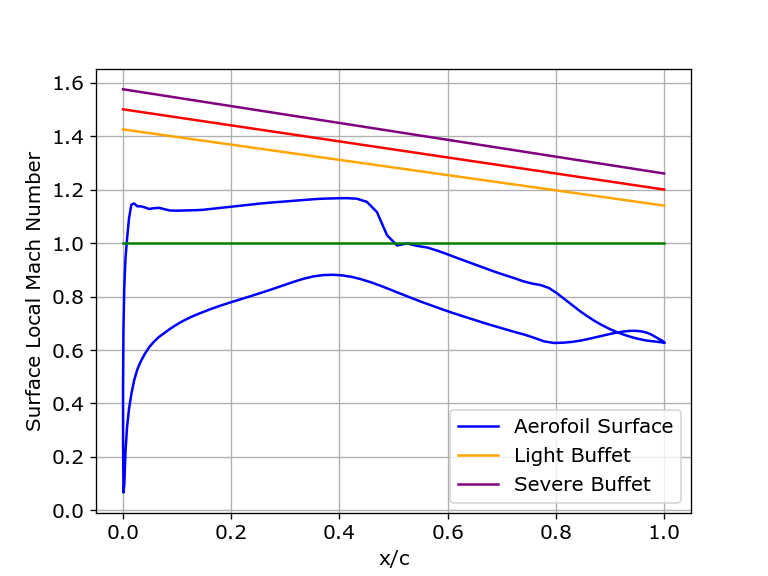

In [8]:
plt.clf()
def airload_ful(filename):
    if not filename:
        print("You need to provide a filename")
        return
    Xful = CPful = []; em = cl = 0; cdv = {} # handle cases where iterative procedure diverged
    try:
        with open(filename, 'r') as f:
            for line in f:
                if line.startswith(' ITERATIVE PROCEDURE HAS DIVERGED'):
                    break
                elif line.startswith('   EM ='):
                    em = line.split()[2]
                elif line.startswith('   CL ='):
                    cl = float(line.split()[2])
                elif line.startswith('  CDV ='):
                    cdv["cdv"] = float(line.split()[2])
                elif line.startswith('  CDV+CD1 ='):
                    cdv["cdv+cd1"] = float(line.split()[2])
                    cdv["cdv+cd2"] = float(line.split()[5])
                elif line.startswith('     T        X         Z          CP        P/P0     EML'):
                    Xful = []
                    CPful = []
                    for line in f:
                        if not line.strip():
                            break
                        else:
                            strs = line.split()
                            Xful.append(float(strs[1]))
                            CPful.append(float(strs[5]))
    except FileNotFoundError:
        print("File does not exist")
    return Xful, CPful, em, cl, cdv


Xful, CPful, em, cl, cdv = airload_ful("../results/report-1.00/0.73-9.00-+2.29/Autorun.FUL")
if cl != 0:
    print("CL: ", cl)
    if abs(cdv['cdv+cd1'] - cdv['cdv+cd1']) <= 0.04: # acceptable error
        print("CD2: ", cdv['cdv+cd2'] - cdv['cdv']) # use viscous cdv
    else:
        print("CD2 (inaccurate): ", cdv['cdv+cd2'] - cdv['cdv'])
mach = float(em)
# https://labs.engineering.asu.edu/aircraft-design/wp-content/uploads/sites/115/2023/03/AIAA-2021-2432-NoahTRuben.pdf
cpstar = 2/(1.4*mach**2)*(((2+0.4*mach**2)/2.4)**3.5-1) # critical pressure coefficient
# def cp(mach): return cpstar*mach**2
# def machloc(cp): return (abs(cp/cpstar))**0.5
plt.plot(Xful, CPful, 'b', label='Aerofoil Surface') 
plt.xlabel('x/c')
plt.ylabel('Surface Local Mach Number')
# plt.gca().invert_yaxis()
plt.grid(True)
plt.plot([0, 1], [1.0, 1.0], 'green')
plt.plot([0, 1], [1.5*0.95, 1.2*0.95], 'orange', label='Light Buffet')
plt.plot([0, 1], [1.5, 1.2], 'red')
plt.plot([0, 1], [1.5*1.05, 1.2*1.05], 'purple', label='Severe Buffet')
plt.legend()
# ax2 = plt.twinx(); ax2.set_ylabel('Surface Local Mach Number'); ax2.set_ylim(0, machloc(-2))
plt.show()
plt.savefig('../results/python/mach_op.png', dpi=300)

In [12]:
foils = ["report"]
machs = [ "{:.2f}".format(0.01*i) for i in range(1, 100)]
aoas = [ "+{:.2f}".format(0.01*i) for i in range(1, 400)]
aoas.extend(["-{:.2f}".format(0.01*i) for i in range(1, 400)])
dict = {}
shock = {}
for foil in foils:
    for mach in machs:
        dict[mach] = {}
        shock[mach] = {}
        for aoa in aoas:
            prop = str(foil) + "-1.00/" + str(mach) + "-9.00-" + str(aoa)
            file = "../results/" + prop + "/Autorun.BRF"
            if os.path.isfile(file):
                Xupper, CPupper, Xlower, CPlower, em, cl, cdv = airload(file)
                xu1, xu2, xl1, xl2 = shload("../results/" + prop + "/Autorun.FUL")
                if cl != 0: # handle cases where iterative procedure diverged
                    dict[mach][aoa] = {}
                    shock[mach][aoa] = {}
                    dict[mach][aoa]["Xupper"] = Xupper
                    dict[mach][aoa]["CPupper"] = CPupper
                    dict[mach][aoa]["Xlower"] = Xlower
                    dict[mach][aoa]["CPlower"] = CPlower
                    dict[mach][aoa]["em"] = em
                    dict[mach][aoa]["cl"] = cl
                    dict[mach][aoa]["cdv"] = cdv
                    shock[mach][aoa] = [xu1, xu2, xl1, xl2]

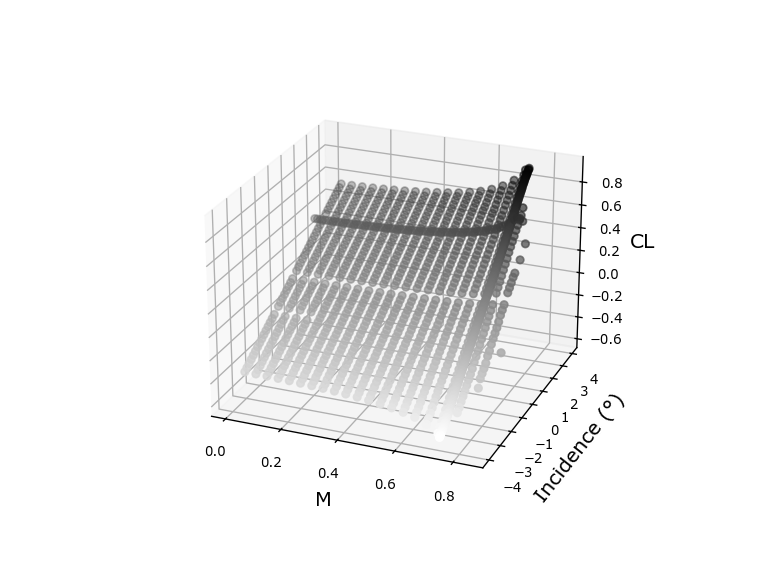

In [13]:
# print([dict[mach][aoa] for mach in dict for aoa in dict[mach]])
plt.clf()
ax = plt.axes(projection='3d') # need much more data to pull this off
ax.figsize = (40, 40)
ax.view_init(30, 120)
ax.set_xlabel('M')
ax.set_ylabel('Incidence (°)')
ax.set_zlabel('CL')
ax.xaxis.set_tick_params(labelsize=8)
ax.yaxis.set_tick_params(labelsize=8)
ax.zaxis.set_tick_params(labelsize=8)
x = [float(mach) for mach in dict for aoa in dict[mach]]
y = [float(aoa) for mach in dict for aoa in dict[mach]]
z = [dict[mach][aoa]["cl"] for mach in dict for aoa in dict[mach]]
ax.scatter3D(x, y, z, c=z, cmap='binary')
ax.view_init(elev=24, azim=-68)
plt.show()
plt.savefig('../results/python/mach_inc_cl.png', dpi=300)


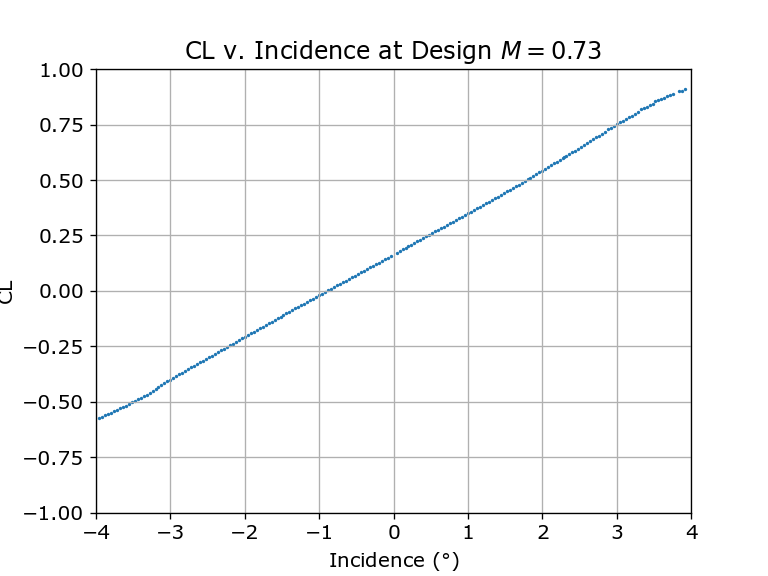

In [14]:
plt.clf()
plt.title('CL v. Incidence at Design $M = 0.73$')
plt.scatter([float(aoa) for aoa in dict['0.73']], [dict['0.73'][aoa]['cl'] for aoa in dict['0.73']], s=1, marker='o')
plt.grid(True)
plt.xlabel('Incidence ($\degree$)')
plt.ylabel('CL')
plt.axis([-4, 4, -1, 1])
plt.show()
plt.savefig('../results/python/cl_inc.png', dpi=300)

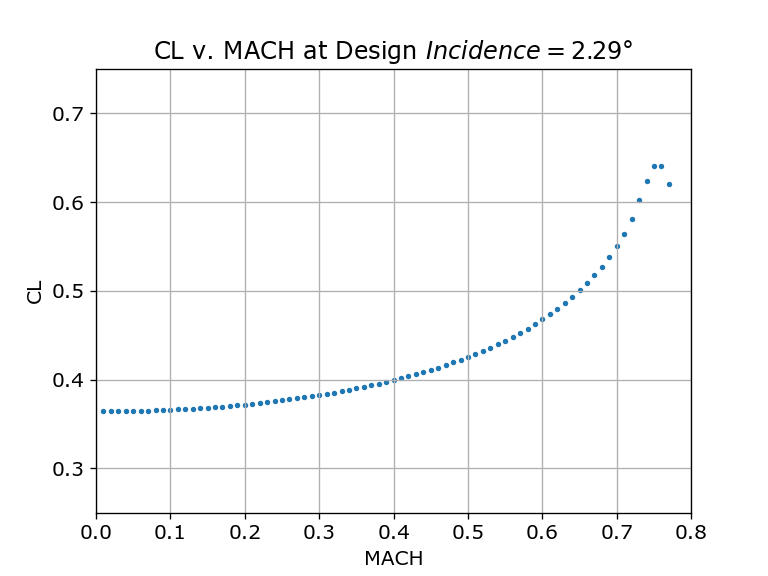

In [15]:
plt.clf()
plt.title('CL v. MACH at Design $Incidence = 2.29\degree$')
plt.scatter([float(mach) for mach in dict if '+2.29' in dict[mach]], [dict[mach]['+2.29']['cl'] for mach in dict if '+2.29' in dict[mach]], s=5, marker='o')
# plt.plot([float(mach) for mach in dict if '+2.29' in dict[mach]], [dict[mach]['+2.29']['cl'] for mach in dict if '+2.29' in dict[mach]])
plt.grid(True)
plt.xlabel('MACH')
plt.ylabel('CL')
plt.axis([0, 0.8, 0.25, 0.75])
plt.show()
plt.savefig('../results/python/cl_mach.png', dpi=300)

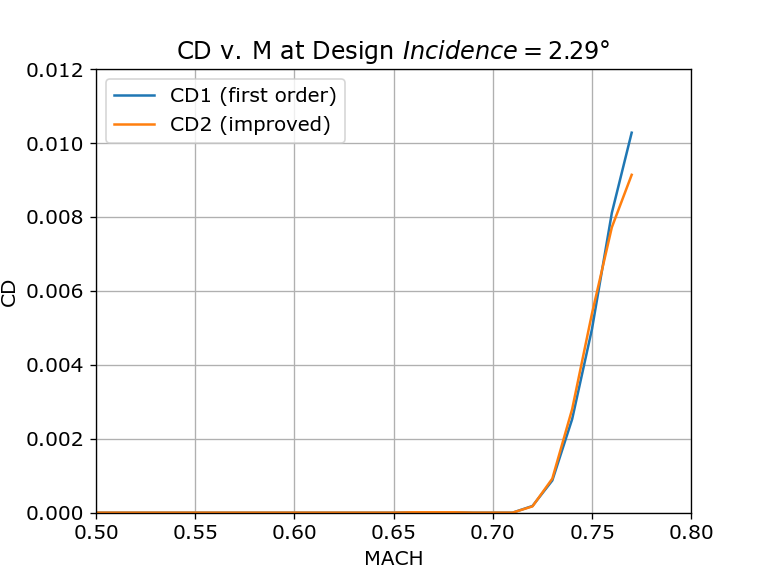

In [16]:
plt.clf()
plt.title('CD v. M at Design $Incidence = 2.29\degree$')
x = [float(mach) for mach in dict if '+2.29' in dict[mach]]
y1 = [dict[mach]['+2.29']['cdv']["cdv+cd1"] - dict[mach]['+2.29']['cdv']["cdv"] for mach in dict if '+2.29' in dict[mach]]
y2 = [dict[mach]['+2.29']['cdv']["cdv+cd2"] - dict[mach]['+2.29']['cdv']["cdv"] for mach in dict if '+2.29' in dict[mach]]
plt.plot(x, y1, label='CD1 (first order)')
plt.plot(x, y2, label='CD2 (improved)')
plt.legend()
plt.grid(True)
plt.xlabel('MACH')
plt.ylabel('CD')
plt.axis([0.5, 0.8, 0, 0.012])
plt.show()
plt.savefig('../results/python/cd_mach.png', dpi=300)

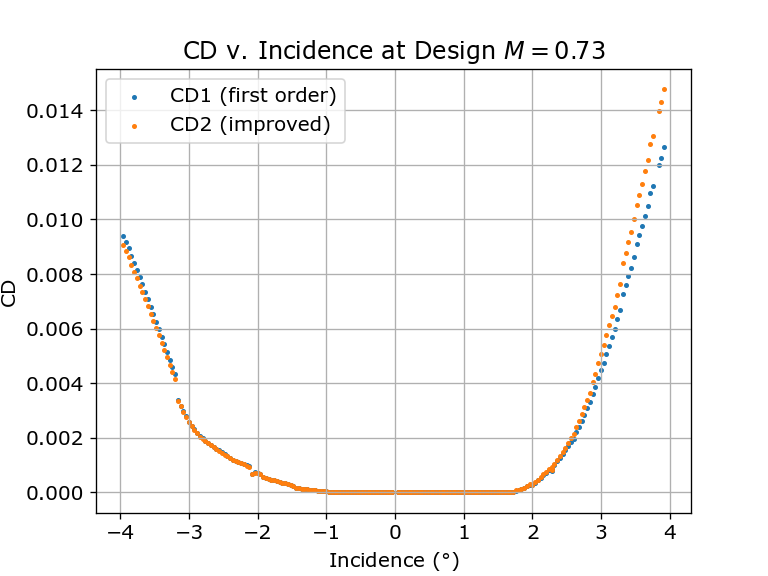

In [17]:
plt.clf()
plt.title('CD v. Incidence at Design $M = 0.73$')
x = [float(aoa) for aoa in dict['0.73']]
y1 = [dict['0.73'][aoa]['cdv']["cdv+cd1"] - dict['0.73'][aoa]['cdv']["cdv"] for aoa in dict['0.73']]
y2 = [dict['0.73'][aoa]['cdv']["cdv+cd2"] - dict['0.73'][aoa]['cdv']["cdv"] for aoa in dict['0.73']]
plt.scatter(x, y1, label='CD1 (first order)', s=4, marker='o')
plt.scatter(x, y2, label='CD2 (improved)', s=4, marker='o')
plt.legend()
plt.grid(True)
plt.xlabel('Incidence ($\degree$)')
plt.ylabel('CD')
plt.show()
plt.savefig('../results/python/cd_inc.png', dpi=300)

In [18]:
plt.clf()
plt.title('CD v. CL around Iterated Conditions')
x = [dict[mach][aoa]['cl'] for mach in dict for aoa in dict[mach]]
y = [dict[mach][aoa]['cdv']["cdv+cd2"] - dict[mach][aoa]['cdv']["cdv"] for mach in dict for aoa in dict[mach]]
plt.scatter(x, y, s=8, marker='o', label='Iterations (Tested)', color='g')
xaoa = [dict['0.73'][aoa]['cl'] for aoa in dict['0.73']]
yaoa = [dict['0.73'][aoa]['cdv']["cdv+cd2"] - dict['0.73'][aoa]['cdv']["cdv"] for aoa in dict['0.73']]
plt.scatter(xaoa, yaoa, s=24, marker='o', label='M = 0.73', color='b')
xm = [dict[mach]['+2.29']['cl'] for mach in dict if '+2.29' in dict[mach]]
ym = [dict[mach]['+2.29']['cdv']["cdv+cd2"] - dict[mach]['+2.29']['cdv']["cdv"] for mach in dict if '+2.29' in dict[mach]]
#plt.scatter(xm, ym, s=24, marker='o', label='Incidence = 2.29', color='r')
plt.plot(xm, ym, label='Incidence = 2.29', color='r', linewidth=2)
plt.legend()
plt.axis([-0.6, 0.8, 0, 0.012])
plt.xlabel('CL')
plt.ylabel('CD')
plt.show()
plt.savefig('../results/python/cd_cl.png', dpi=300)

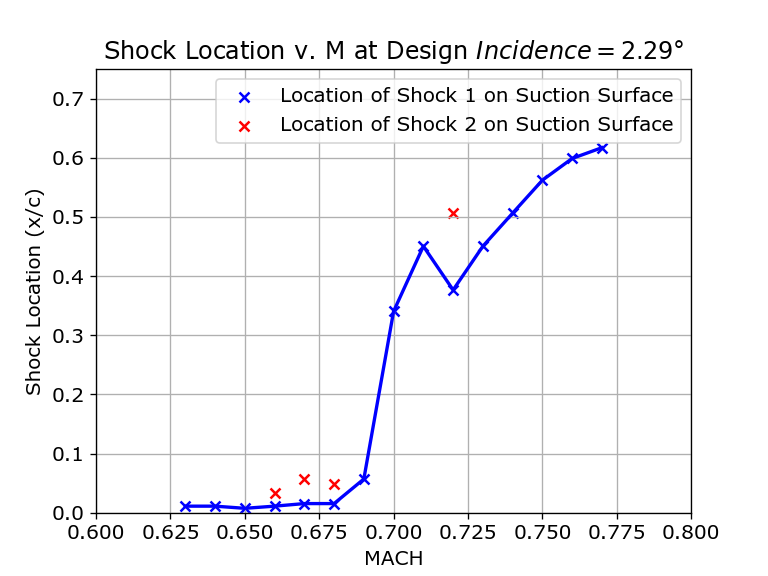

In [13]:
plt.clf()
plt.title('Shock Location v. M at Design $Incidence = 2.29\degree$')
x1 = [float(mach) for mach in shock if '+2.29' in shock[mach] and shock[mach]['+2.29'][0] != 0]
y1 = [shock[mach]['+2.29'][0] for mach in shock if '+2.29' in shock[mach] and shock[mach]['+2.29'][0] != 0]
x2 = [float(mach) for mach in shock if '+2.29' in shock[mach] and shock[mach]['+2.29'][1] != 0]
y2 = [shock[mach]['+2.29'][1] for mach in shock if '+2.29' in shock[mach] and shock[mach]['+2.29'][1] != 0]
plt.plot(x1, y1, c='b', linewidth=2)
plt.scatter(x1, y1, label='Location of Shock 1 on Suction Surface', c='b', s=36, marker='x')
plt.scatter(x2, y2, label='Location of Shock 2 on Suction Surface', c='r', s=36, marker='x')
plt.legend()
plt.grid(True)
plt.xlabel('MACH')
plt.ylabel('Shock Location (x/c)')
plt.axis([0.6, 0.8, 0, 0.75])
plt.show()
plt.savefig('../results/python/shloc_mach.png', dpi=300)

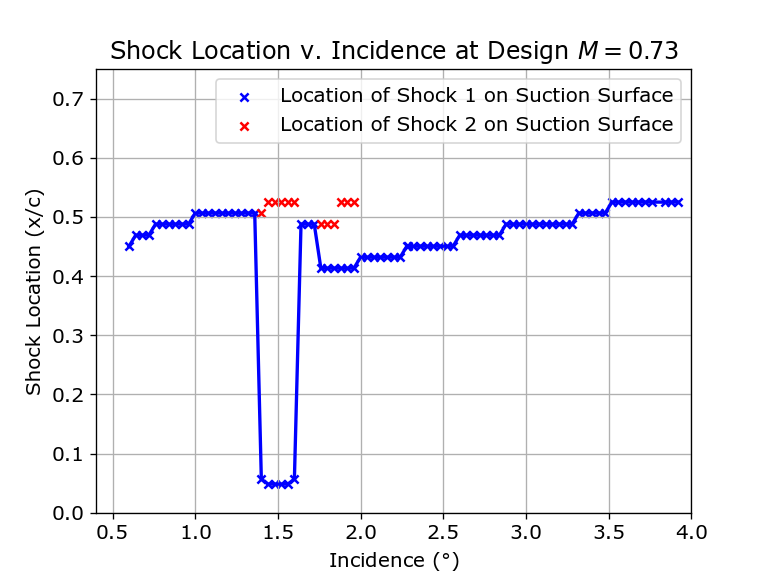

In [14]:
plt.clf()
plt.title('Shock Location v. Incidence at Design $M = 0.73$')
x1 = [float(aoa) for aoa in shock['0.73'] if shock['0.73'][aoa][0] != 0]
y1 = [shock['0.73'][aoa][0] for aoa in shock['0.73'] if shock['0.73'][aoa][0] != 0]
x2 = [float(aoa) for aoa in shock['0.73'] if shock['0.73'][aoa][1] != 0]
y2 = [shock['0.73'][aoa][1] for aoa in shock['0.73'] if shock['0.73'][aoa][1] != 0]
plt.plot(x1, y1, c='b', linewidth=2)
plt.scatter(x1, y1, label='Location of Shock 1 on Suction Surface', c='b', s=24, marker='x')
plt.scatter(x2, y2, label='Location of Shock 2 on Suction Surface', c='r', s=24, marker='x')
plt.legend()
plt.grid(True)
plt.xlabel('Incidence ($\degree$)')
plt.ylabel('Shock Location (x/c)')
plt.axis([0.4, 4, 0.00, 0.75])
plt.show()
plt.savefig('../results/python/shloc_inc.png', dpi=300)

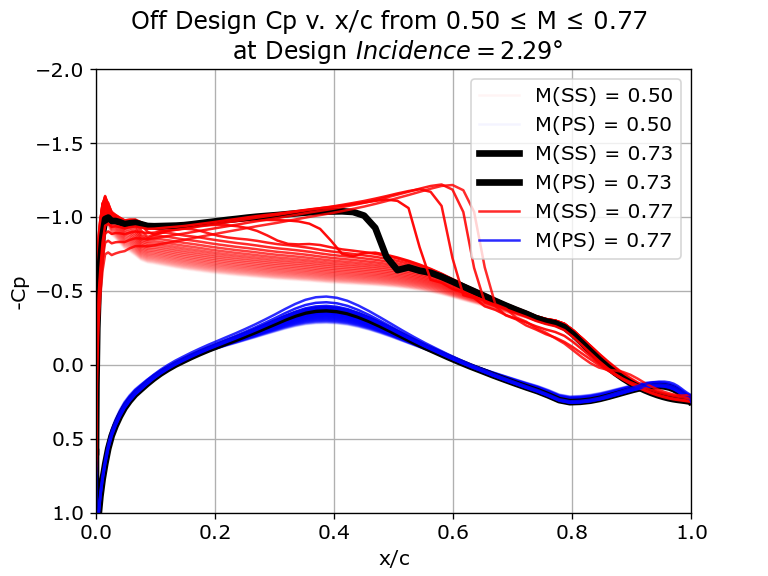

In [21]:
plt.clf()
machref = '0.73'; aoa = '+2.29'
for mach in [ "{:.2f}".format(0.01*i) for i in range(50, 80)]:
    if aoa in dict[mach]:
        Xupper = dict[mach][aoa]['Xupper']
        CPupper = dict[mach][aoa]['CPupper']
        Xlower = dict[mach][aoa]['Xlower']
        CPlower = dict[mach][aoa]['CPlower']
        mach = float(mach)
        cpstar = 2/1.4/mach/mach*(((2+0.4*mach*mach)/2.4)**3.5-1)
        if float(mach) == float(machref):
            plt.plot(Xupper, CPupper, 'k', linewidth=4, label='M(SS) = 0.73') 
            plt.plot(Xlower, CPlower, 'k', linewidth=4, label='M(PS) = 0.73')
        elif float(mach) == 0.50 or float(mach) == 0.77:
            plt.plot(Xupper, CPupper, 'r', alpha=1-abs(float(mach)-float(machref))/0.24, label='M(SS) = {:.2f}'.format(mach)) 
            plt.plot(Xlower, CPlower, 'b', alpha=1-abs(float(mach)-float(machref))/0.24, label='M(PS) = {:.2f}'.format(mach))
        else:
            plt.plot(Xupper, CPupper, 'r', alpha=1-abs(float(mach)-float(machref))/0.24)
            plt.plot(Xlower, CPlower, 'b', alpha=1-abs(float(mach)-float(machref))/0.24)
        # plt.plot([0, 1], [cpstar, cpstar], 'g', label='Cp* ( M = 1.0 )')
plt.legend()
plt.xlabel('x/c')
plt.ylabel('-Cp')
plt.axis([0, 1, -2, 1])
plt.gca().invert_yaxis()
plt.grid(True)
plt.title('Off Design Cp v. x/c from 0.50 ≤ M ≤ 0.77 \n at Design $Incidence = 2.29\degree$')
plt.show()
plt.savefig('../results/python/cp_od_mach.png', dpi=300)

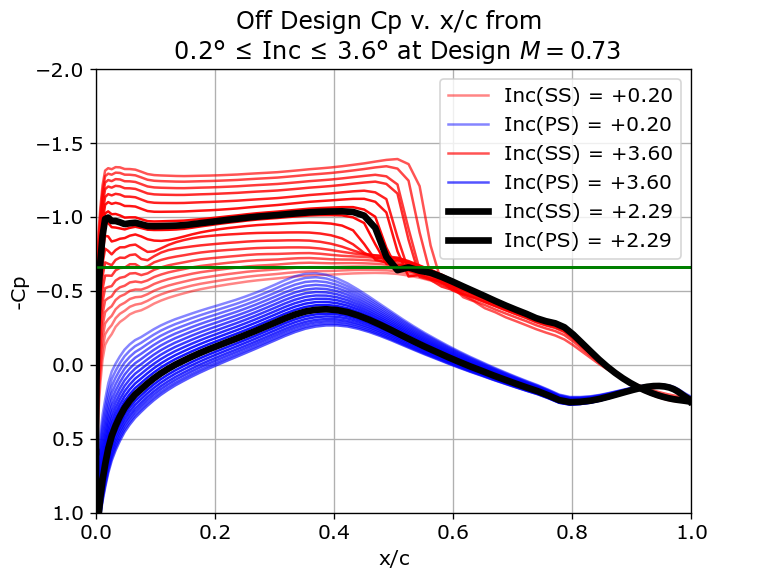

In [19]:
plt.clf()
mach = '0.73'; aoaref = '+2.29'
aoal = [ "+{:.2f}".format(0.05*i) for i in range(4, 75)]
aoal.extend(['+2.29'])
for aoa in aoal:
    if aoa in dict['0.73']:
        Xupper = dict[mach][aoa]['Xupper']
        CPupper = dict[mach][aoa]['CPupper']
        Xlower = dict[mach][aoa]['Xlower']
        CPlower = dict[mach][aoa]['CPlower']
        em = float(mach)
        cpstar = 2/1.4/em/em*(((2+0.4*em*em)/2.4)**3.5-1)
        if float(aoa) == float(aoaref):
            plt.plot(Xupper, CPupper, 'k', linewidth=4, label='Inc(SS) = +2.29')
            plt.plot(Xlower, CPlower, 'k', linewidth=4, label='Inc(PS) = +2.29')
        elif float(aoa) == 0.2 or float(aoa) == 3.6:
            plt.plot(Xupper, CPupper, 'r', alpha=(1-abs(float(aoa)-float(aoaref))/4), label='Inc(SS) = {}'.format(aoa))
            plt.plot(Xlower, CPlower, 'b', alpha=(1-abs(float(aoa)-float(aoaref))/4), label='Inc(PS) = {}'.format(aoa))
        else:
            plt.plot(Xupper, CPupper, 'r', alpha=(1-abs(float(aoa)-float(aoaref))/4))
            plt.plot(Xlower, CPlower, 'b', alpha=(1-abs(float(aoa)-float(aoaref))/4))
        plt.plot([0, 1], [cpstar, cpstar], 'g') # label='Cp* ( M = 1.0 )'
plt.legend()
plt.xlabel('x/c')
plt.ylabel('-Cp')
plt.axis([0, 1, -2, 1])
plt.gca().invert_yaxis()
plt.grid(True)
plt.title('Off Design Cp v. x/c from \n 0.2° ≤ Inc ≤ 3.6° at Design $M = 0.73$')
plt.show()
plt.savefig('../results/python/cp_od_inc.png', dpi=300)